In [1]:
# Imports

import numpy as np
from scipy.integrate import cumulative_trapezoid as ct      # The magic cumulative numerical integration function
import matplotlib.pyplot as plt


In [2]:
## Defining Functions - Used for Calcualting the Integral, Truncation Errors, and Propagating All Errors ##


# Truncation Error V1 - Unused but included for reference. Produces same result as trunc_err but is less computationally efficient

def old_version_trunc_err(x, y):                    # Based on eq 14 in the brief

    error = np.zeros(len(x))

    for i in range(2, len(x)):
        
        Ix = ct(y[i-2:i+1], x[i-2:i+1])             # Only calculating Ix and I2x for 3 elements at a time
        I2x = ct(y[i-2:i+1:2], x[i-2:i+1:2])

        error[i] = error[i-2] + ( (Ix[-1] - I2x[-1]) / 3 ) 
    
    return error


# Truncation Error Final Version - Produces the same result, but only calculates 3 cumulative integrals in total rather than two for every i

def trunc_err(x, y):                                                # Based on eq 11 in the brief
    
    error = np.zeros(len(x))

    Ix_total = ct(y, x, initial=0)                                  # Calculating one cumulative integral for all data, even data points and odd data points
    Ix_even = ct(y[::2], x[::2], initial=0)
    Ix_odd = ct(y[1::2], x[1::2], initial=0)

    error[::2] = (Ix_total[::2] - Ix_even)/3                        # Splicing the final error array to add the even error points
    error[1::2] = ((Ix_total[1::2] - Ix_total[1]) - Ix_odd)/3       # Splicing the final error array to add the odd error points, and removing the first point of the total integral.

    return error 


# Propagating The Errors - Combining the intrisic errors with the truncation errors, and propagating the total errors through the cumulative integration

def prop_uncert(x, y, uy):              # Based on eq 18 in the brief
    
    N = len(y)

    trunc_errs = trunc_err(x, y)        # Finding the truncation error for the dataset

    deltax = x[1]-x[0]                  # The width of the sub-intervals
    uncerts = np.zeros(N)

    for i in range(N):                  # Looping over all points
        j=0                             # Going from 0 to i, cumulatively propagating and summing the uncertatinties using the known derivatives of the Trapezoid Rule equation
        while j<=i:

            if j == 0 or j == i :                               
                uncerts[i] += ((0.5*deltax)**2) * (uy[i])**2    # Including the uncertainty of each point summed over, as per eq 18

            else:
                uncerts[i] += (deltax**2) * (uy[i])**2
            j +=1

    final_errors = np.sqrt(uncerts + ((trunc_errs**2)/3))       # Summing the final two error arrays 

    return final_errors 

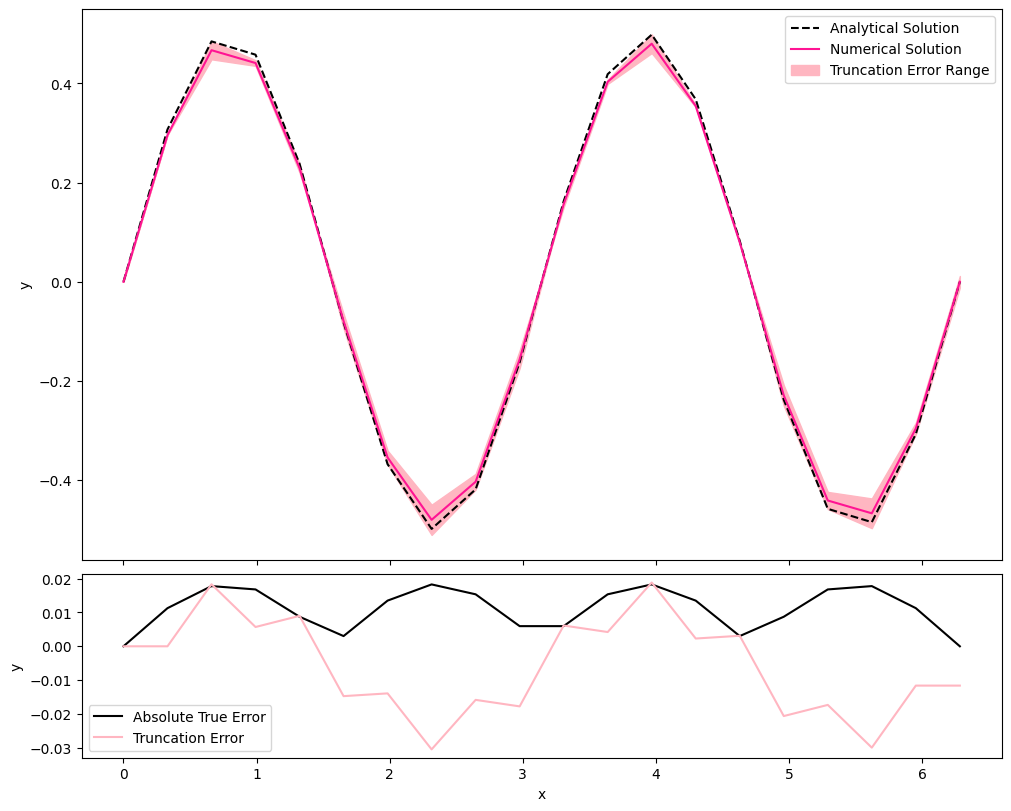

In [3]:
## 3.1 Dataing the Methods on a Known Integral

# Creating a Function that Takes in Uniform, Fixed Samples and Returns Integral Values with Truncation Error Estimates 

def num_est_errors(x,y):

    Y = ct(y, x, initial = 0)
    uY = trunc_err(x,y)

    return Y, uY


# Choosing a Data Function 

def test_func(x):
    return np.cos(2*x)

def test_int(x):                                # Definite integral, hence the second term
    return 0.5*np.sin(2*x) - 0.5*np.sin(0)     


# Generating Points

x = np.linspace(0, 2*np.pi, 20)                 # Generating a set of uniform points from 0 to 2 pi
y = test_func(x)                                # Generating the fixed samples


# Comparing the known result with the integral function

y_ana = test_int(x)                             # Analytical solution
y_num, uy_num = num_est_errors(x, y)            # Numerical soultion with truncation errors


# Plotting the Two and Comparing Absolute True Error with Estimated Truncation Error

fig, (ax1, ax2) = plt.subplots(2,1, layout = 'constrained', sharex =True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[10,8])

ax1.plot(x, y_ana, label='Analytical Solution', color='k', linestyle='dashed')
ax1.plot(x, y_num, label='Numerical Solution', color='deeppink')
ax1.fill_between(x, y_num-uy_num, y_num+uy_num, color='lightpink', label='Truncation Error Range')
ax1.set_ylabel('y')
ax1.legend()

ax2.plot(x, np.abs(y_ana-y_num), label='Absolute True Error', color='black')            # Absolute true error
ax2.plot(x, (uy_num), label='Truncation Error', color='lightpink')                      # Truncation error
ax2.set_ylabel('y')
ax2.legend()

plt.xlabel('x')
plt.show()


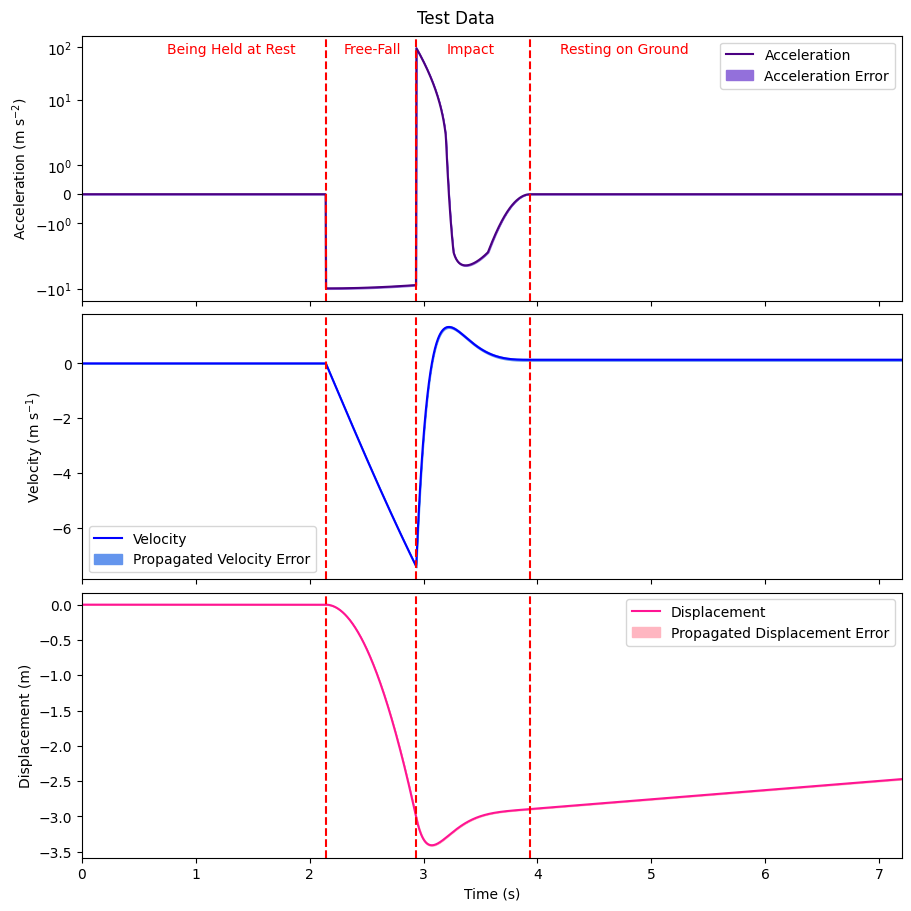

In [4]:
## Part 3.2 - Integrating the Test Data, Finding and Propagating the Uncertainties


# Defining a function that takes in the name of a file and outputs the displacement with uncertainties

def displacement(filename): 

    time, acc = np.loadtxt(filename, delimiter=',', skiprows=1, unpack=True)

    uacc = 0.02*acc

    vel = ct(acc, time, initial=0)
    uvel = prop_uncert(time, acc, uacc)

    disp = ct(vel, time, initial=0)
    udisp = prop_uncert(time, vel, uvel)

    return time, acc, uacc, vel, uvel, disp, udisp


# Integrating the test data and plotting the results

Test = displacement('project2_test_data.csv')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, layout = 'constrained', sharex =True, figsize=[9,9])        # Creating the plot

#Acceleration
ax1.plot(Test[0], Test[1], label='Acceleration', color= 'indigo')
ax1.fill_between(Test[0], (Test[1] - Test[2]), (Test[1] + Test[2]), color='mediumpurple', label='Acceleration Error')
ax1.set_ylabel(r'Acceleration (m s$^{-2}$)')
ax1.set_yscale('symlog')
ax1.legend()

#Velocity
ax2.plot(Test[0], Test[3], label='Velocity', color= 'blue')
ax2.fill_between(Test[0], (Test[3] - Test[4]), (Test[3] + Test[4]), color='cornflowerblue', label='Propagated Velocity Error')
ax2.set_ylabel(r'Velocity (m s$^{-1}$)')
ax2.legend()

#Displacement
ax3.plot(Test[0], Test[5], label='Displacement', color= 'deeppink')
ax3.fill_between(Test[0], (Test[5] - Test[6]), (Test[5]+Test[6]), color='lightpink', label='Propagated Displacement Error')
ax3.set_ylabel('Displacement (m)')
ax3.legend()

#Plotting the Different Time Stages
timesteps = [2.143333333333333535e+00, 2.936666666666666980e+00, 3.933333333333333570e+00]          # Set of transition timesteps found manually
axs = [ax1, ax2, ax3]

for ax in axs:                                             
    for t in timesteps:
        ax.axvline(t, 0, 1, color='r', linestyle='dashed')

ax1.annotate('Being Held at Rest', [0.75, 75], color='r')       # Caption Positions Chosen by Hand
ax1.annotate('Free-Fall', [2.3, 75], color='r')
ax1.annotate('Impact', [3.2, 75], color='r')
ax1.annotate('Resting on Ground', [4.2, 75], color='r')

plt.xlabel('Time (s)')
plt.xlim(0, np.max(Test[0]))

plt.suptitle('Test Data')
plt.show()

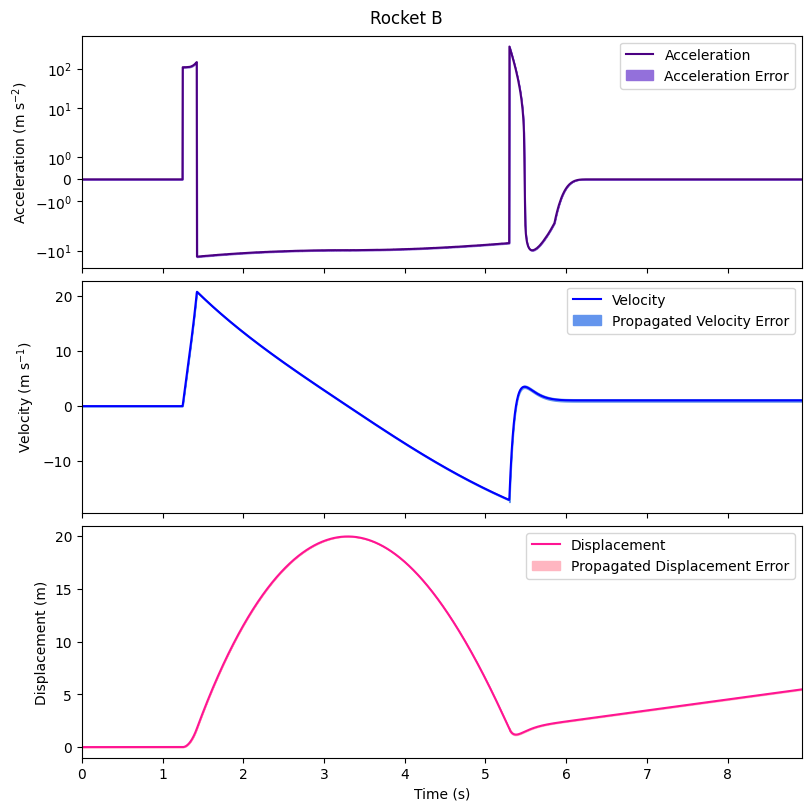

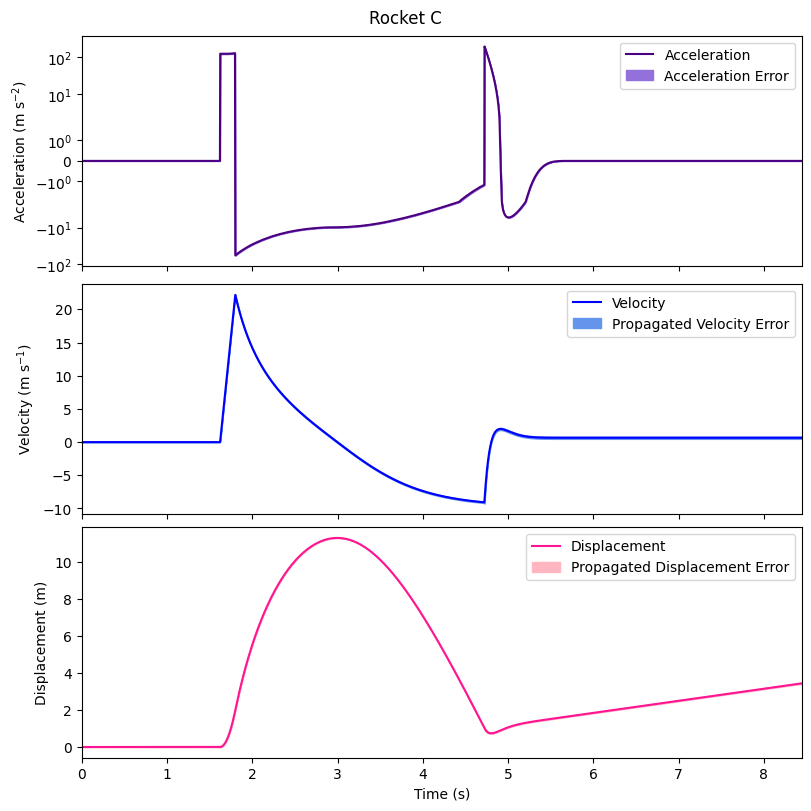

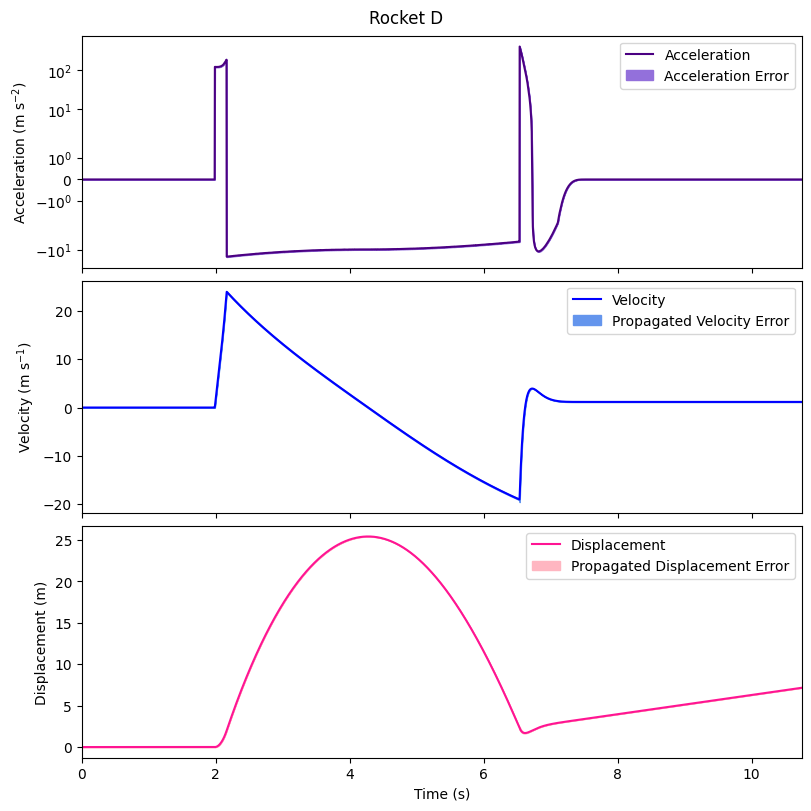

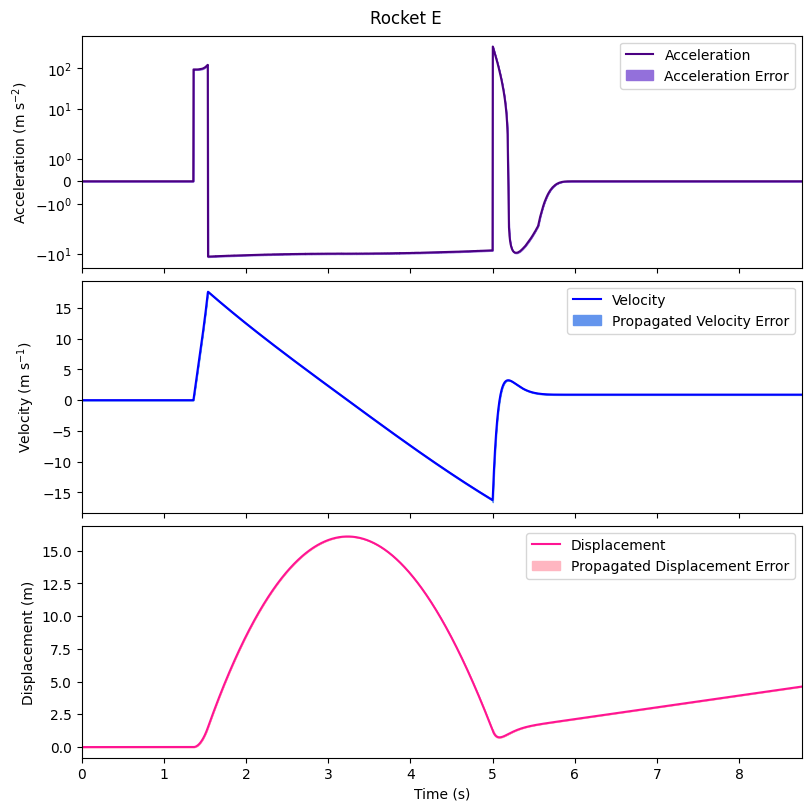

In [5]:
# 3.3 Integrating the Rocket Data to Find the Winner

# Finding the Integrals for Each Dataset

files = ['project2_dataA.csv', 'project2_dataB.csv', 'project2_dataC.csv', 'project2_dataD.csv', 'project2_dataE.csv']
Datasets = []

for file in files:
    Datasets.append(displacement(file))


# Creating a Generic Plotting Function for 4 of the 5 Datasets Based on the Code Used for the Test Data

def finalplots(Data, title):

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, layout = 'constrained', sharex =True, figsize=[8,8])        # Creating the plot

    #Acceleration
    ax1.plot(Data[0], Data[1], label='Acceleration', color= 'indigo')
    ax1.fill_between(Data[0], (Data[1] - Data[2]), (Data[1] + Data[2]), color='mediumpurple', label='Acceleration Error')
    ax1.set_ylabel(r'Acceleration (m s$^{-2}$)')
    ax1.set_yscale('symlog')
    ax1.legend()

    #Velocity
    ax2.plot(Data[0], Data[3], label='Velocity', color= 'blue')
    ax2.fill_between(Data[0], (Data[3] - Data[4]), (Data[3] + Data[4]), color='cornflowerblue', label='Propagated Velocity Error')
    ax2.set_ylabel(r'Velocity (m s$^{-1}$)')
    ax2.legend()

    #Displacement
    ax3.plot(Data[0], Data[5], label='Displacement', color= 'deeppink')
    ax3.fill_between(Data[0], (Data[5] - Data[6]), (Data[5]+Data[6]), color='lightpink', label='Propagated Displacement Error')
    ax3.set_ylabel('Displacement (m)')
    ax3.legend()

    plt.xlabel('Time (s)')
    plt.xlim(0, np.max(Data[0]))
    plt.suptitle(title)

    plt.show()
    return


# Plotting Data from Rockets B-E with the Above Function

names = ['Rocket A', 'Rocket B', 'Rocket C', 'Rocket D', 'Rocket E']

for Data, name in zip(Datasets[1:], names[1:]):
    finalplots(Data, name)


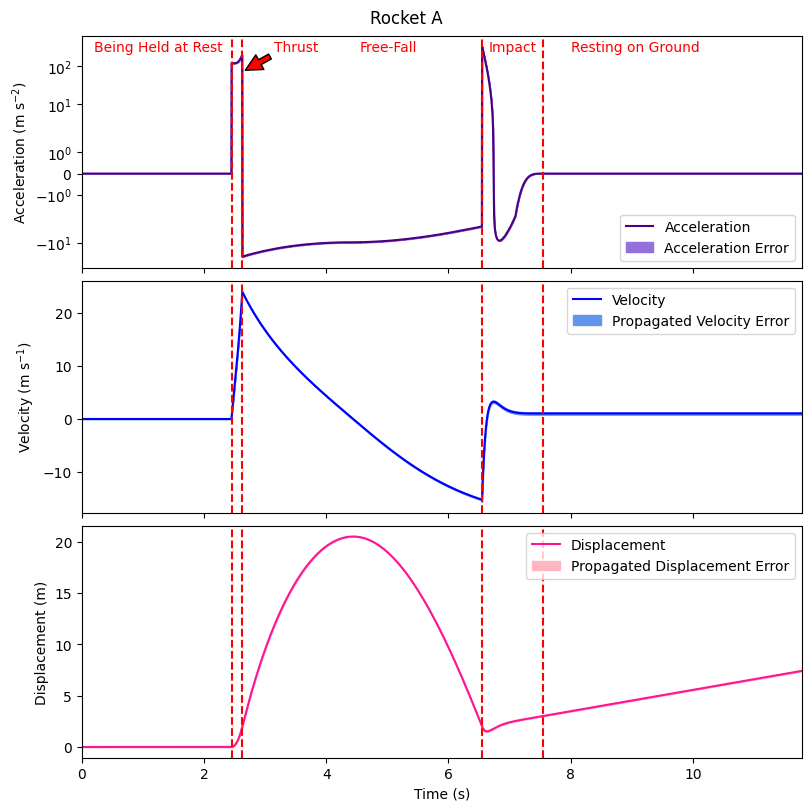

In [6]:
# Plotting Rocket A Data Manually (to place the different stage seperator lines)

DataA = Datasets[0]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, layout = 'constrained', sharex =True, figsize=[8,8])        # Creating the plot

#Acceleration
ax1.plot(DataA[0], DataA[1], label='Acceleration', color= 'indigo')
ax1.fill_between(DataA[0], (DataA[1] - DataA[2]), (DataA[1] + DataA[2]), color='mediumpurple', label='Acceleration Error')
ax1.set_ylabel(r'Acceleration (m s$^{-2}$)')
ax1.set_yscale('symlog')
ax1.legend(loc='lower right')

#Velocity
ax2.plot(DataA[0], DataA[3], label='Velocity', color= 'blue')
ax2.fill_between(DataA[0], (DataA[3] - DataA[4]), (DataA[3] + DataA[4]), color='cornflowerblue', label='Propagated Velocity Error')
ax2.set_ylabel(r'Velocity (m s$^{-1}$)')
ax2.legend()

#Displacement
ax3.plot(DataA[0], DataA[5], label='Displacement', color= 'deeppink')
ax3.fill_between(DataA[0], (DataA[5] - DataA[6]), (DataA[5]+DataA[6]), color='lightpink', label='Propagated Displacement Error')
ax3.set_ylabel('Displacement (m)')
ax3.legend()

#Plotting the Different Time Stages
timesteps = [2.450000000000000178e+00, 2.626666666666666927e+00, 6.550000000000000711e+00, 7.550000000000000711e+00]          # Set of transition timesteps found manually
axs = [ax1, ax2, ax3]

for ax in axs:                                             
    for t in timesteps:
        ax.axvline(t, 0, 1, color='r', linestyle='dashed')

ax1.annotate('Being Held at Rest', [0.2, 250], color='r')                                                           # Caption Positions Chosen by Hand
ax1.annotate('Thrust', xy=[2.65, 75], xytext=[3.15,250], arrowprops=dict(facecolor='r', shrink=0.05), color='r')     # Added fancy arrow
ax1.annotate('Free-Fall', [4.55, 250], color='r')
ax1.annotate('Impact', [6.65, 250], color='r')
ax1.annotate('Resting on Ground', [8, 250], color='r')

plt.xlabel('Time (s)')
plt.xlim(0, np.max(DataA[0]))
plt.suptitle('Rocket A')

plt.show()


The maximum displacement of Rocket A was: 20.509013131025206 +/- 0.013822687451085787 m, with a coverage factor of 1.
The maximum displacement of Rocket B was: 19.98613978898706 +/- 0.009401223810619093 m, with a coverage factor of 1.
The maximum displacement of Rocket C was: 11.308426852365793 +/- 0.010030868289152164 m, with a coverage factor of 1.
The maximum displacement of Rocket D was: 25.428339739383304 +/- 0.01284868333426342 m, with a coverage factor of 1.
The maximum displacement of Rocket E was: 16.077392810564838 +/- 0.007989222900400907 m, with a coverage factor of 1.


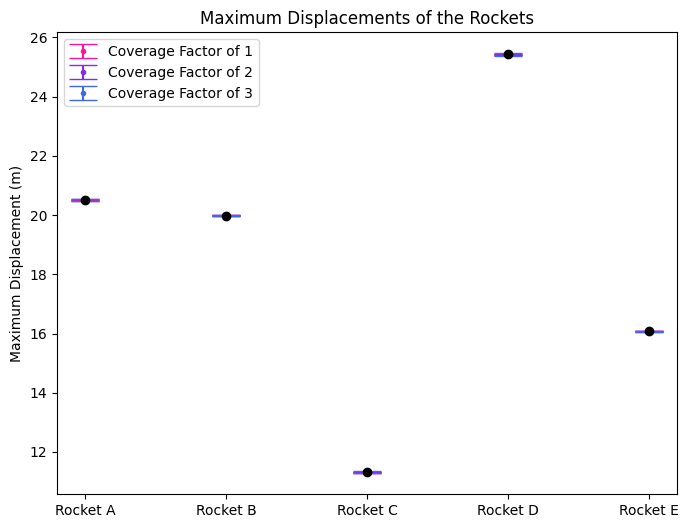

In [7]:
# Calculating the Maximum Heights and Plotting w Different Coverage Factors

maxdisp = []
umaxdisp = []

for data in Datasets:               
    max = np.max(data[5])                               # Finding each maximum displacement
    maxdisp.append(max)
    loc = int(((np.where(data[5] == max))[0])[0])       # Looks hideous but returns the index of the maximum displacement as an inetger without warnings appearing about depreciated code
    umaxdisp.append((data[6])[loc])

maxdisp = np.array(maxdisp)
umaxdisp = np.array(umaxdisp)

for i in range(len(names)):
    print('The maximum displacement of', names[i], 'was:', maxdisp[i], '+/-', umaxdisp[i], 'm, with a coverage factor of 1.')

# Plotting the Maximum Displacements (with Optional Scaling Factor for Visibility)

plt.figure(figsize=(8,6))

xpos = np.arange(5)
plt.scatter(xpos, maxdisp, color='k', zorder=10)

colours = ['deeppink', 'blueviolet', 'royalblue']

for i in range(3):  
    plt.errorbar(x=xpos, y=maxdisp, yerr=umaxdisp*(i+1), color= colours[i], capsize=10, fmt='o', markersize=3, label=f'Coverage Factor of {i+1}')

plt.xticks(xpos, names)
plt.ylabel('Maximum Displacement (m)')
plt.title('Maximum Displacements of the Rockets')
plt.legend()

plt.show()